In [ ]:
!pip install keras==2.0 -q
!pip install tensorflow==1.13.0rc1 -q

     |████████████████████████████████| 191 kB 10.0 MB/s 
     |████████████████████████████████| 454.4 MB 9.0 kB/s 
     |████████████████████████████████| 4.0 MB 54.2 MB/s 
     |████████████████████████████████| 1.2 MB 36.6 MB/s 
     |████████████████████████████████| 462 kB 59.9 MB/s 
     |████████████████████████████████| 92.7 MB 49 kB/s 
     |████████████████████████████████| 3.0 MB 46.3 MB/s 
     |████████████████████████████████| 367 kB 57.8 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.13.0rc1 which is incompatible.


In [ ]:
import sys
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm 

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.layers import Input, Dense, LeakyReLU 
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda 
from tensorflow.keras.models import Model 
from tensorflow.keras.losses import binary_crossentropy 

from tensorflow.keras import backend as K 
from IPython.display import clear_output 
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard 
from scipy.stats import multivariate_normal

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() 
 

x_train = x_train.astype('float32') / 255. 
x_test  = x_test .astype('float32') / 255. 
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) 

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
batch_size = 100 
latent_dim = 10 
dropout_rate = 0.3 
start_lr = 0.0001 

In [ ]:
def create_vae(): 
    models = {} 
 
    def apply_bn_and_dropout(x):  
        return Dropout(dropout_rate)(BatchNormalization()(x)) 
        
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) 
    x = Flatten()(input_img) 
    x = Dense(256, activation='relu')(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x) 
 
    z_mean = Dense(latent_dim)(x) 
    
    z_log_var = Dense(latent_dim)(x) 
 
    def sampling(args): 
        z_mean, z_log_var = args 
 
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        
        return z_mean + K.exp(z_log_var / 2) * epsilon
      
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l) 
    
    models["z_meaner"] = Model(input_img, z_mean) 
    
    models["z_lvarer"] = Model(input_img, z_log_var) 
 
    z = Input(shape=(latent_dim, )) 
    x = Dense(128)(z)  
    x = LeakyReLU()(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(256)(x) 
    x = LeakyReLU()(x) 
    x = apply_bn_and_dropout(x) 
    x = Dense(28*28, activation='sigmoid')(x) 
    decoded = Reshape((28, 28, 1))(x) 

    models["decoder"] = Model(z, decoded, name='Decoder') 
 
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='VAE')

    def vae_loss(x, decoded): 
        x = K.reshape(x, shape=(batch_size, 28*28)) 
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) 
        xent_loss = 28*28*binary_crossentropy(x, decoded) 
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        return (xent_loss + kl_loss)/2/28/28

    return models, vae_loss

models, vae_loss = create_vae() 
vae = models["vae"] 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss)

In [ ]:
digit_size = 28 

def plot_digits(*args, invert_colors=False): 
    args = [x.squeeze() for x in args]  
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n)) 

    for i in range(n):
        for j in range(len(args)): 
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: 
        figure = 1-figure 

    plt.figure(figsize=(2*n, 2*len(args))) 
    plt.imshow(figure, cmap='Greys_r') 
    plt.grid(False) 
    ax = plt.gca() 
    ax.get_xaxis().set_visible(False)  
    ax.get_yaxis().set_visible(False) 
    plt.show() 

n = 15  
digit_size = 28


In [ ]:
latent_distrs = []
epochs = []
 
save_epochs = set([i*5 for i in range(0,25)])
 
imgs = x_test[:batch_size]
n_compare = 10
 
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]
 
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() 
 
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])
 
        epochs.append(epoch)
 
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))
 
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

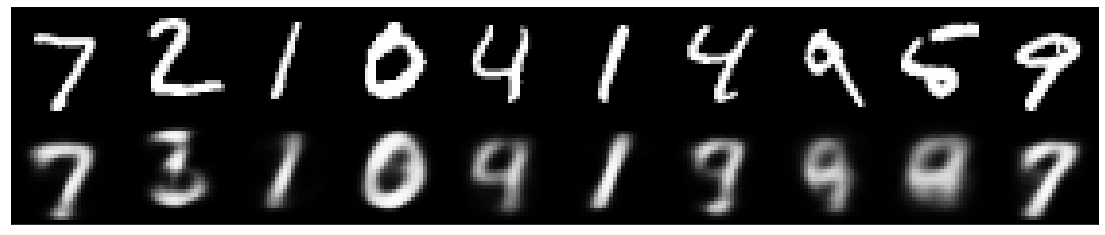

60000/60000 [==============================] - 16s 273us/sample - loss: 0.1048 - val_loss: 0.0924
Epoch 7/10
60000/60000 [==============================] - 16s 264us/sample - loss: 0.1015 - val_loss: 0.0898
Epoch 8/10
60000/60000 [==============================] - 16s 262us/sample - loss: 0.0990 - val_loss: 0.0878
Epoch 9/10
60000/60000 [==============================] - 16s 263us/sample - loss: 0.0974 - val_loss: 0.0865
Epoch 10/10
60000/60000 [==============================] - 16s 264us/sample - loss: 0.0962 - val_loss: 0.0856


In [ ]:
vae.fit(x_train, x_train, shuffle=True, epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) 